In [40]:
import pandas as pd
from theano import shared
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100




In [41]:
dta = pd.read_csv('Reco_HH_14Days.csv')

dta[['TIMESTAMP_START']] = (dta[['TIMESTAMP_START']].applymap(str).applymap(
    lambda s: "{}/{}/{} {}:{}".format(s[0:4], s[4:6], s[6:8], s[8:10], s[10:12])))

dta['TIMESTAMP_START'] = dta['TIMESTAMP_START'].astype('datetime64[ns]')

#mask = (dta['TIMESTAMP_START'] > '2005-05-01') & (dta['TIMESTAMP_START'] <= '2005-05-14')

dta.set_index(['TIMESTAMP_START'], inplace=True)

#dta = dta.resample('1H').mean()

dta.reset_index(inplace=True)



In [42]:
def norml(data):
    norm_data = (data-np.max(data))/(np.min(data)-np.max(data))
    return norm_data

In [44]:

ts = pd.DataFrame(dta.loc[:,['TIMESTAMP_START', 'TA_F','SW_IN_F','RECO_NT_VUT_50']])
ts['RECO_NT_VUT_50'] = norml(ts['RECO_NT_VUT_50'])
ts['TA_F'] = norml(ts['TA_F'])


In [45]:
num_forecast = 48 * 2  # two days
data_training = ts[:-num_forecast]
data_test = ts[-num_forecast:]
#data_training
#data_training['TIMESTAMP_START'].tail(1)

In [48]:
from functools import partial
from scipy.stats import norm
def schon_basis(x):
    return x 

def polynomial_basis(x, power):
    return x ** power

def gaussian_basis(x, mu, sigma):
    return norm(loc=np.mean(x), scale=sigma).pdf(x).astype(np.float32)

def _expand(x, bf, bf_args):
    return np.stack([bf(x, bf_arg) for bf_arg in bf_args], axis=1)

def expand_polynomial(x, degree=3):
    return _expand(x, bf=polynomial_basis, bf_args=range(1, degree + 1))

def expand_gaussian(x, mus=np.linspace(0, 1, 9), sigma=1):
    return _expand(x, bf=partial(gaussian_basis, sigma=sigma), bf_args=mus)


expand = expand_polynomial
#expand = expand_gaussian

In [132]:
#to check the basis function test it with values
#expand_polynomial(np.array([0.5, 1.5]), degree=3)

In [49]:
x=data_training['TA_F'].values
y = data_training['RECO_NT_VUT_50'].values


In [52]:

Phi = expand(x)
Phi_shared = shared(Phi)

with pm.Model() as model:
    w_0 = pm.Normal('w_0', mu=0, sigma=10)
    w_r = pm.Normal('w_r', mu=0, sigma=10, shape=Phi.shape[1])
    noise = 0.1
    mu = w_0 + w_r.dot(Phi_shared.T)
    
    t_obs = pm.Normal('t_obs', mu=mu, sigma=noise, observed=y)

In [53]:
with model:
    trace = pm.sample(10000, return_inferencedata=True,tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_r, w_0]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 32 seconds.
There were 3716 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5731280438426916, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


/var/folders/v1/58yl0t_n2ng9vz587pfjhtpc0000gn/T/ipykernel_40482/3892976860.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, compact=False)


array([[<AxesSubplot:title={'center':'w_0'}>,
        <AxesSubplot:title={'center':'w_0'}>],
       [<AxesSubplot:title={'center':'w_r\n0'}>,
        <AxesSubplot:title={'center':'w_r\n0'}>],
       [<AxesSubplot:title={'center':'w_r\n1'}>,
        <AxesSubplot:title={'center':'w_r\n1'}>],
       [<AxesSubplot:title={'center':'w_r\n2'}>,
        <AxesSubplot:title={'center':'w_r\n2'}>]], dtype=object)

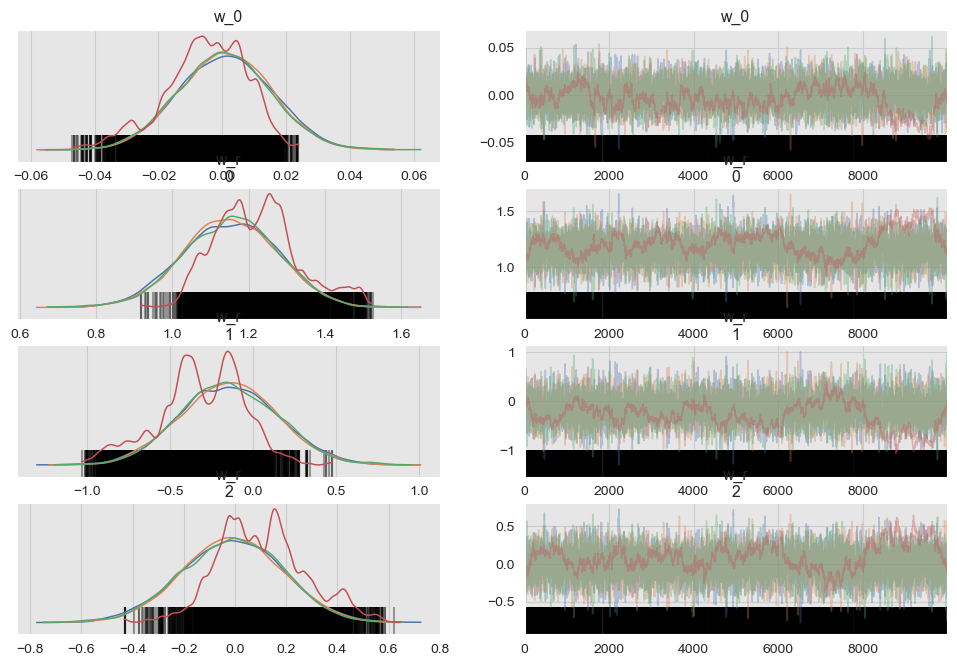

In [54]:
pm.traceplot(trace, compact=False)

array([<AxesSubplot:title={'center':'w_r\n0'}>,
       <AxesSubplot:title={'center':'w_r\n1'}>,
       <AxesSubplot:title={'center':'w_r\n2'}>], dtype=object)

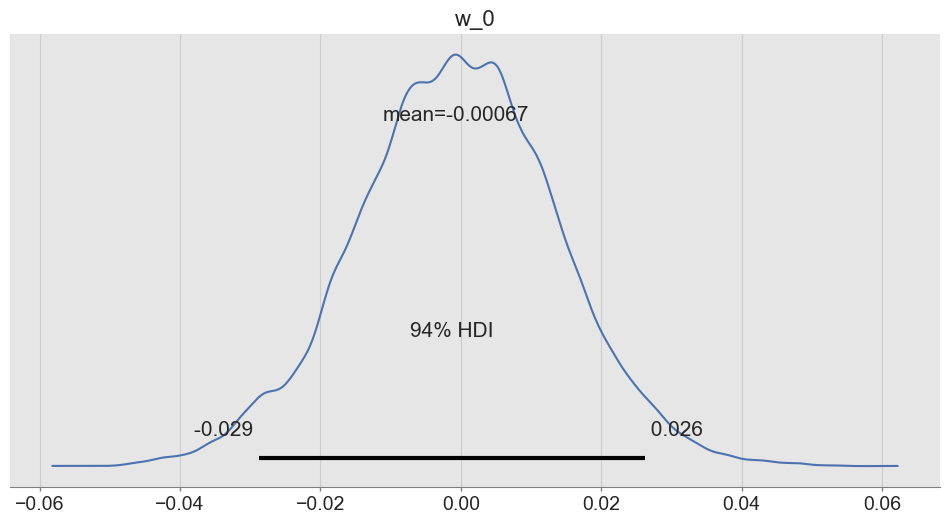

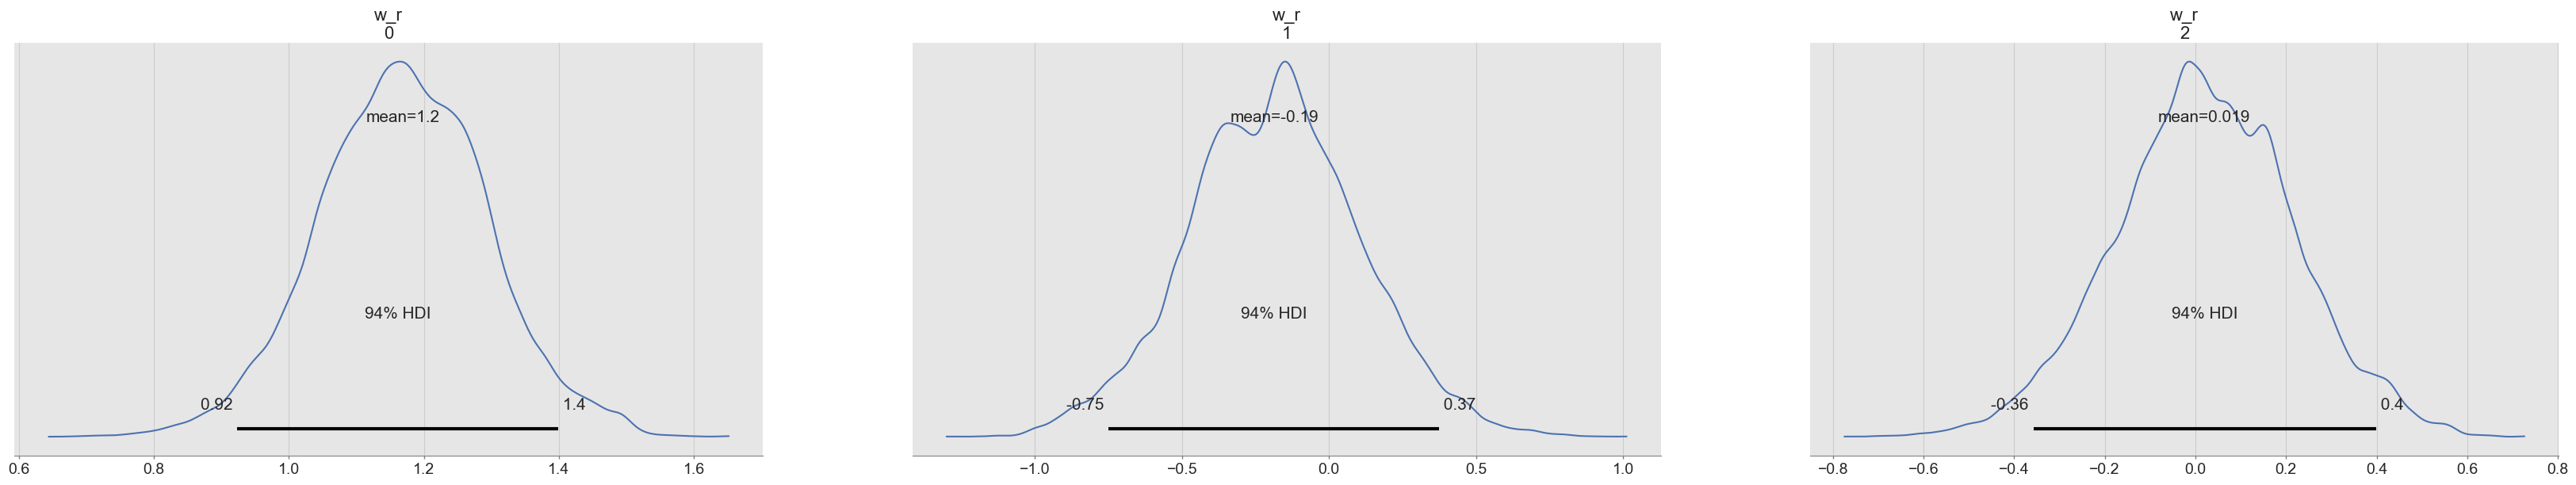

In [55]:
pm.plot_posterior(trace, var_names="w_0")
pm.plot_posterior(trace, var_names="w_r")

In [168]:
#with model:
    
   # data_train_pred_samples = pm.sample_posterior_predictive(trace, model=model, samples=10000)['t_obs']

    
    

/Users/sabazamankhani/miniforge3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [169]:
#m_1 = np.mean(data_train_pred_samples, axis=0)
#s_1 = np.std(data_train_pred_samples, axis=0)


In [56]:
#posterior predictive samples for a separate test set 
Phi_shared.set_value(expand(data_test['TA_F'].values))
predictive_samples = pm.sample_posterior_predictive(trace, model=model, samples=10000)['t_obs']

/Users/sabazamankhani/miniforge3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [57]:
mean = np.mean(predictive_samples, axis=0)
std = np.std(predictive_samples, axis=0)

[Text(0.5, 1.0, 'Model Predictions'), Text(0.5, 0, 'time'), Text(0, 0.5, '')]

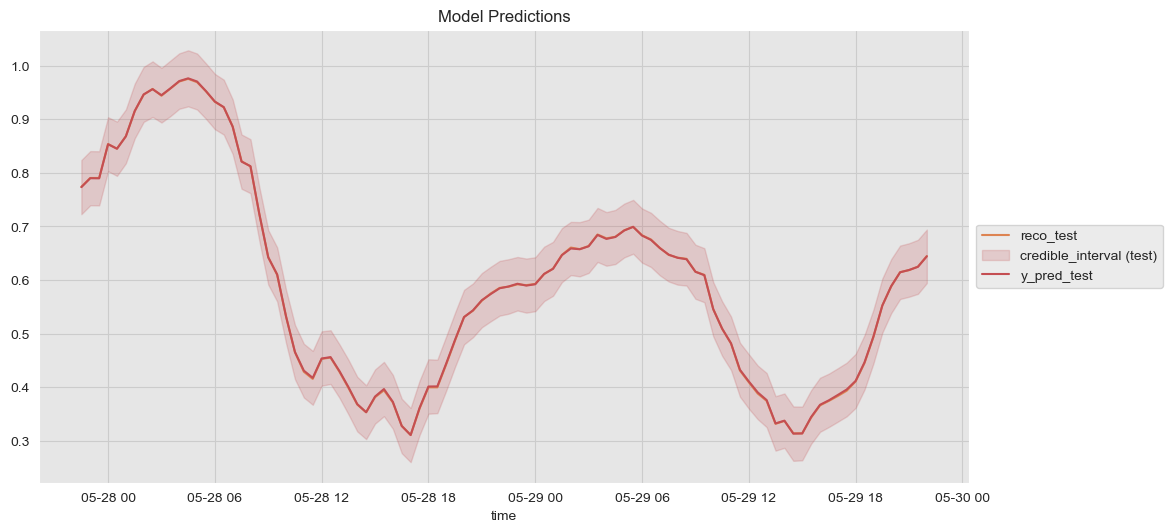

In [58]:
#'TIMESTAMP_START', 'TA_F','SW_IN_F','RECO_NT_VUT_50'
fig, ax = plt.subplots()
#sns.lineplot(x=data_training['TIMESTAMP_START'].values.flatten(), y=data_training['RECO_NT_VUT_50'].values.flatten(), color=sns_c[0], label='reco_train', ax=ax)
sns.lineplot(x=data_test['TIMESTAMP_START'].values.flatten(), y=data_test['RECO_NT_VUT_50'].values.flatten(), color=sns_c[1], label='reco_test', ax=ax)
#ax.fill_between(
#    x=data_training['TIMESTAMP_START'].values.flatten(), 
 #   y1=m_1-s_1,
#    y2=m_1+s_1, 
#    color=sns_c[2], 
#    alpha=0.2, 
 #   label='credible_interval (train)'
#)
#sns.lineplot(x=data_test['TIMESTAMP_START'].values.flatten(), y=m, color=sns_c[2], label='y_pred_train', ax=ax)
ax.fill_between(
    x=data_test['TIMESTAMP_START'].values.flatten(), 
    y1=mean-std, 
    y2=mean+std, 
    color=sns_c[3], 
    alpha=0.2, 
    label='credible_interval (test)'
)
sns.lineplot(x=data_test['TIMESTAMP_START'].values.flatten(), y=mean, color=sns_c[3], label='y_pred_test', ax=ax)
#ax.axvline(x=data_training['TIMESTAMP_START'].values.flatten()[-1], color=sns_c[7], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Model Predictions', xlabel='time', ylabel='')